In [1]:
import numpy as np
import os
from skimage.io import imread
from skimage.transform import resize
from DataProcessor import DataProcessor
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
# from Metrics import Metrics
from Model import QuadraticDiscriminantAnalysis
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder

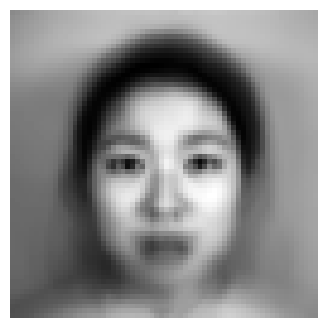

In [2]:
current_directory = os.getcwd()
image_processor = DataProcessor(current_directory)
image_processor.load_images()
image_processor.calculate_mean_image()

In [3]:
image_processor.demean_images()
# image_processor.normalize_images()

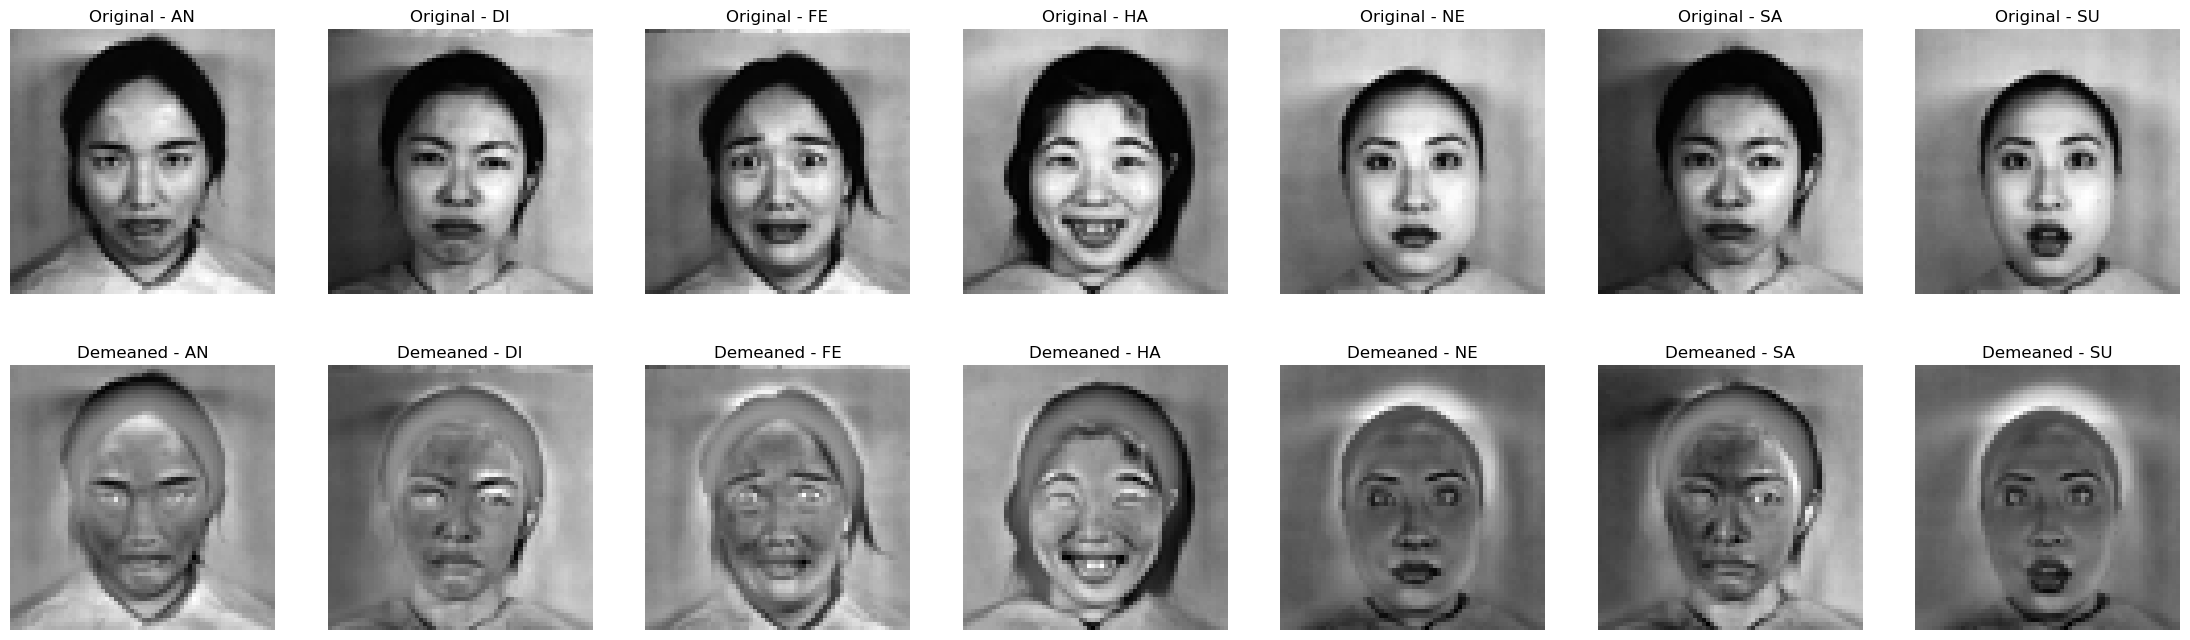

In [4]:
image_processor.visualize_selected_images()

In [5]:
dataset = image_processor.data
images = np.array([list(img) for img in dataset['Image']])

In [6]:
class PCA:
    def __init__(self, n_components):
        self.n_components = n_components
        self.components = None
        self.eigenvectors = None
        self.eigenvalues = None
        self.mean = None

    def fit(self, X):
        # Mean centering
        self.mean = np.mean(X, axis=0)
        X = (X - self.mean)
        # Covariance matrix
        cov_matrix = np.cov(X.T)

        # Eigenvalues and eigenvectors
        eigenvalues, eigenvectors = np.linalg.eigh(cov_matrix)  # Use eigh for symmetric matrices

        # Sort eigenvectors
        eigenvectors = eigenvectors.T
        idxs = np.argsort(abs(eigenvalues))[::-1]
        eigenvalues = eigenvalues[idxs]
        eigenvectors = eigenvectors[idxs]
        self.eigenvectors = eigenvectors
        self.eigenvalues = eigenvalues
        # Store first n eigenvectors (use real part if complex)
        self.components = np.real(eigenvectors[0:self.n_components])

    def transform(self, X):
        # Project data
        X = (X - self.mean)
        return np.dot(X, self.components.T)
    
    def inverse_transform(self, X):
        # Inverse transform to the original space
        return np.dot(X, self.components) + self.mean


In [7]:
def plot_eigenfaces(eigenfaces):
    num_eigenfaces = len(eigenfaces)
    num_rows = int(np.ceil(num_eigenfaces / 5))
    num_columns = min(5, num_eigenfaces)
    fig, axes = plt.subplots(num_rows, num_columns, figsize=(3 * num_columns, 3 * num_rows))
    for i in range(num_rows):
        for j in range(num_columns):
            index = i * num_columns + j
            if index < num_eigenfaces:
                ax = axes[i, j] if num_rows > 1 else axes[j]
                ax.imshow(eigenfaces[index], cmap='gray')
                ax.axis('off')

    plt.show()

In [8]:
def plot_inverse_transformation(reconstructed_images, unique_classes, image_size):
    
    print("inverse transform images: ")
    fig, axes = plt.subplots(2, len(unique_classes), figsize=(4* len(unique_classes),12))
    for i, class_label in enumerate(unique_classes):
        class_indices = np.where(labels == class_label)[0]
        random_index = np.random.choice(class_indices)
        original_image = images[random_index].reshape(image_size)
        reconstructed_image = reconstructed_images[random_index]

        axes[0, i].imshow(original_image, cmap='gray')
        axes[0, i].axis('off')
        axes[0, i].set_title(f'Class {class_label} - Original')

        axes[1,i].imshow(reconstructed_image, cmap='gray')
        axes[1,i].axis('off')
        axes[1,i].set_title(f'Class {class_label} - Reconstructed')

    plt.tight_layout()
    plt.show()

In [9]:
n_components=10
image_size = (64,64)
pca = PCA(n_components)
pca.fit(images)
transformed_images = pca.transform(images)
eigenfaces = pca.components.reshape((n_components, *image_size))

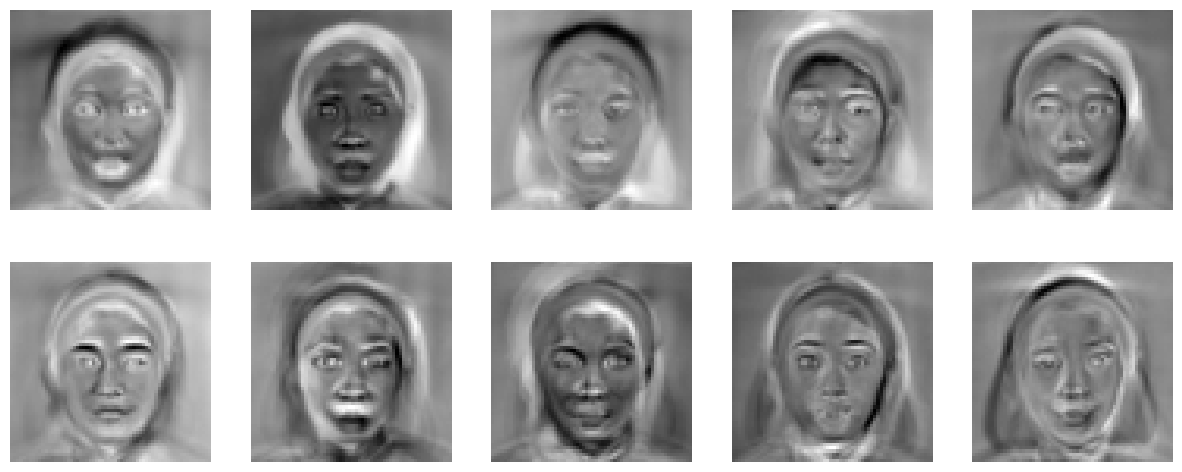

In [10]:
plot_eigenfaces(eigenfaces)

In [11]:
def plot_eigenvalues(eigenvalues):
    plt.plot(eigenvalues, 'o-', markersize=2)
    y_max = eigenvalues[0]
    plt.ylim(0, y_max)
    plt.xlabel('number')
    plt.ylabel('eignevalue')
    plt.grid(True)
    plt.show()

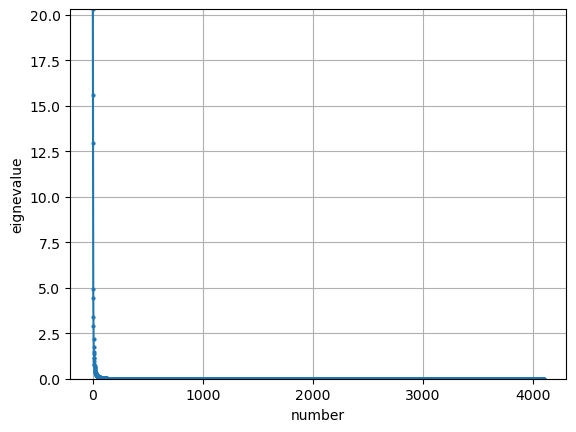

In [12]:
plot_eigenvalues(pca.eigenvalues)

In [13]:
labels = dataset['Expression']
unique_classes = list(set(labels))
reconstructed_images = pca.inverse_transform(transformed_images)
reconstructed_images = reconstructed_images.reshape(-1, *image_size)

inverse transform images: 


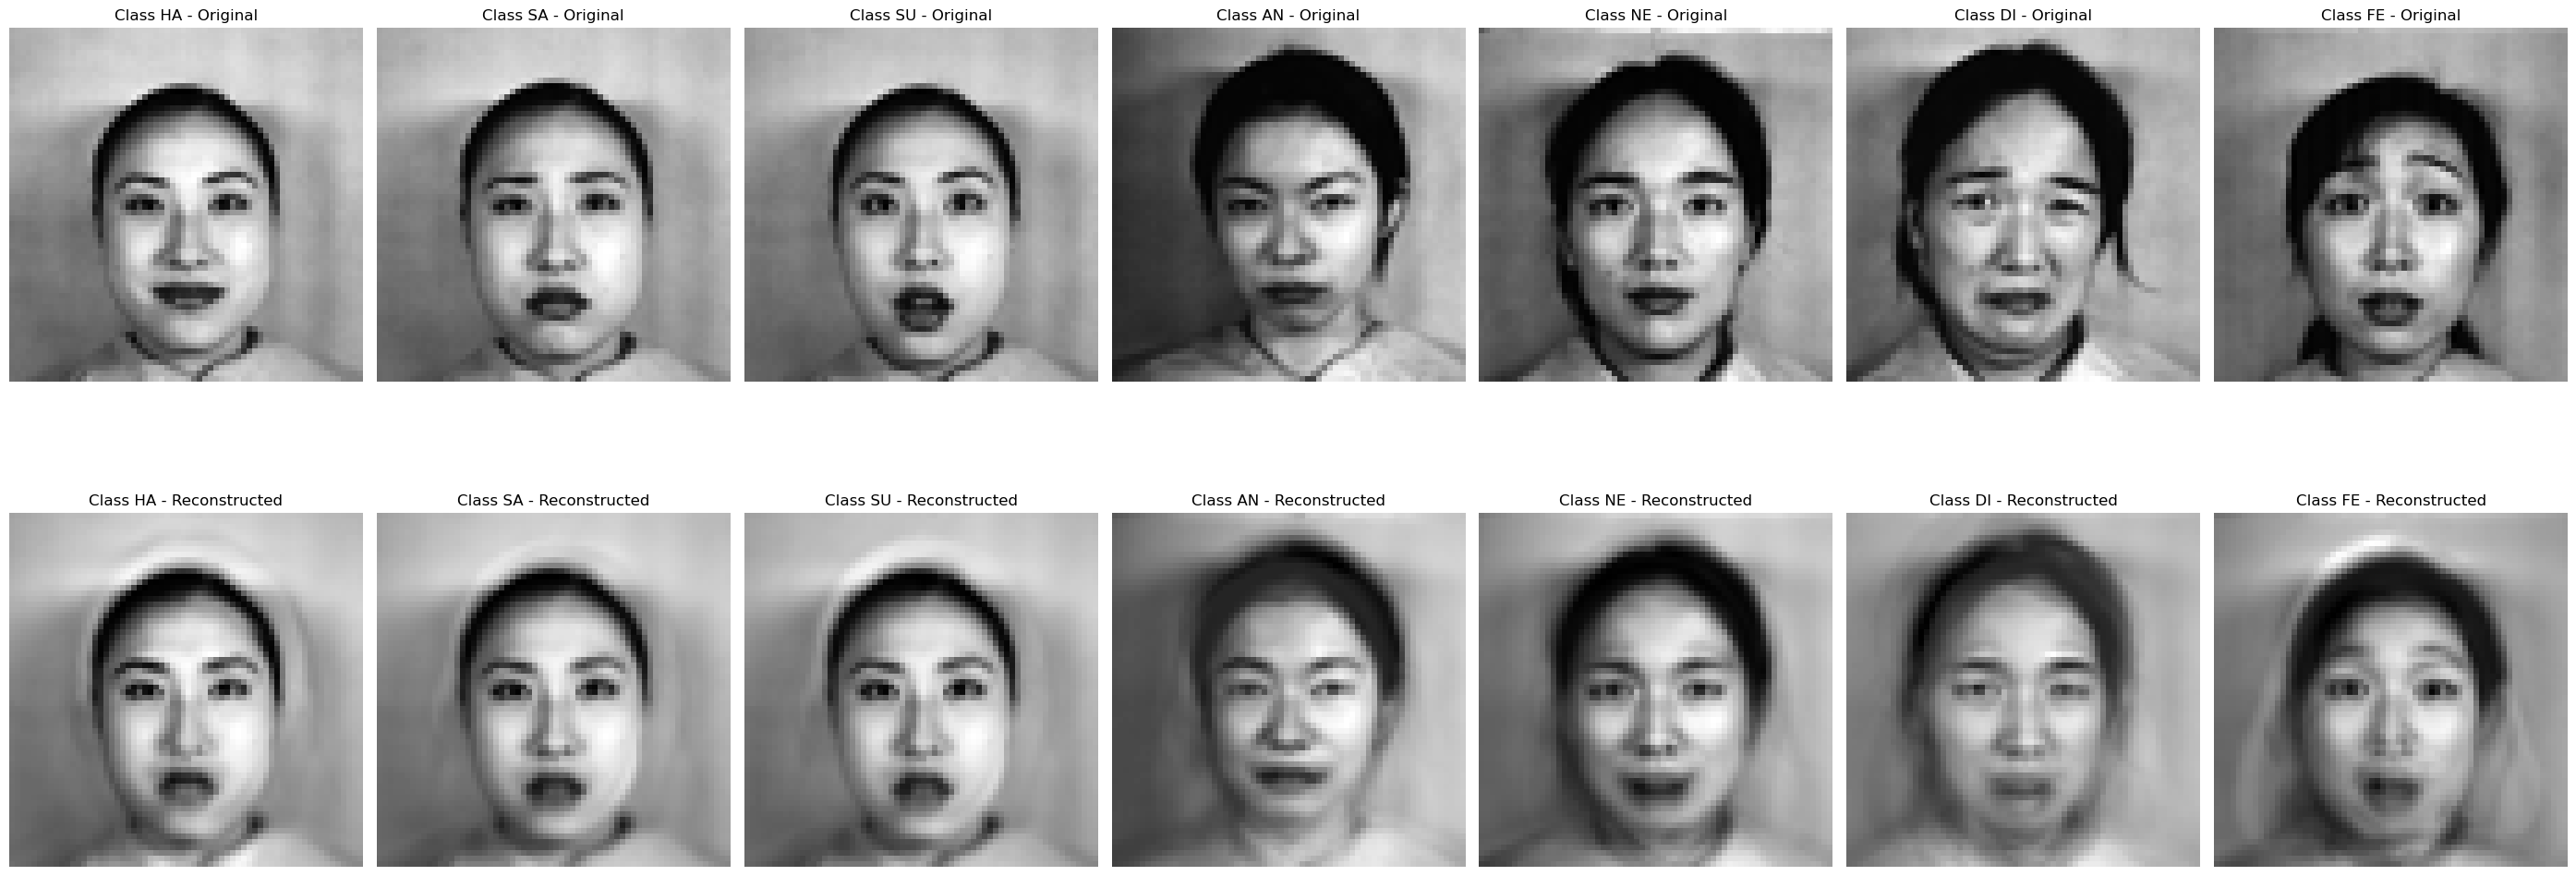

In [14]:
plot_inverse_transformation(reconstructed_images, unique_classes, image_size)

In [15]:
n_components_2d = 2
image_size = (64,64)
pca_2d = PCA(n_components_2d)
pca_2d.fit(images)
transformed_images_2d = pca_2d.transform(images)
eigenfaces_2d = pca_2d.components.reshape((n_components_2d, *image_size))

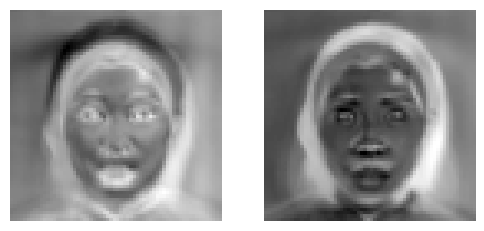

In [16]:
plot_eigenfaces(eigenfaces_2d)

In [17]:
labels = dataset['Expression']
unique_classes = list(set(labels))
reconstructed_images_2d = pca_2d.inverse_transform(transformed_images_2d)
reconstructed_images_2d = reconstructed_images_2d.reshape(-1, *image_size)

inverse transform images: 


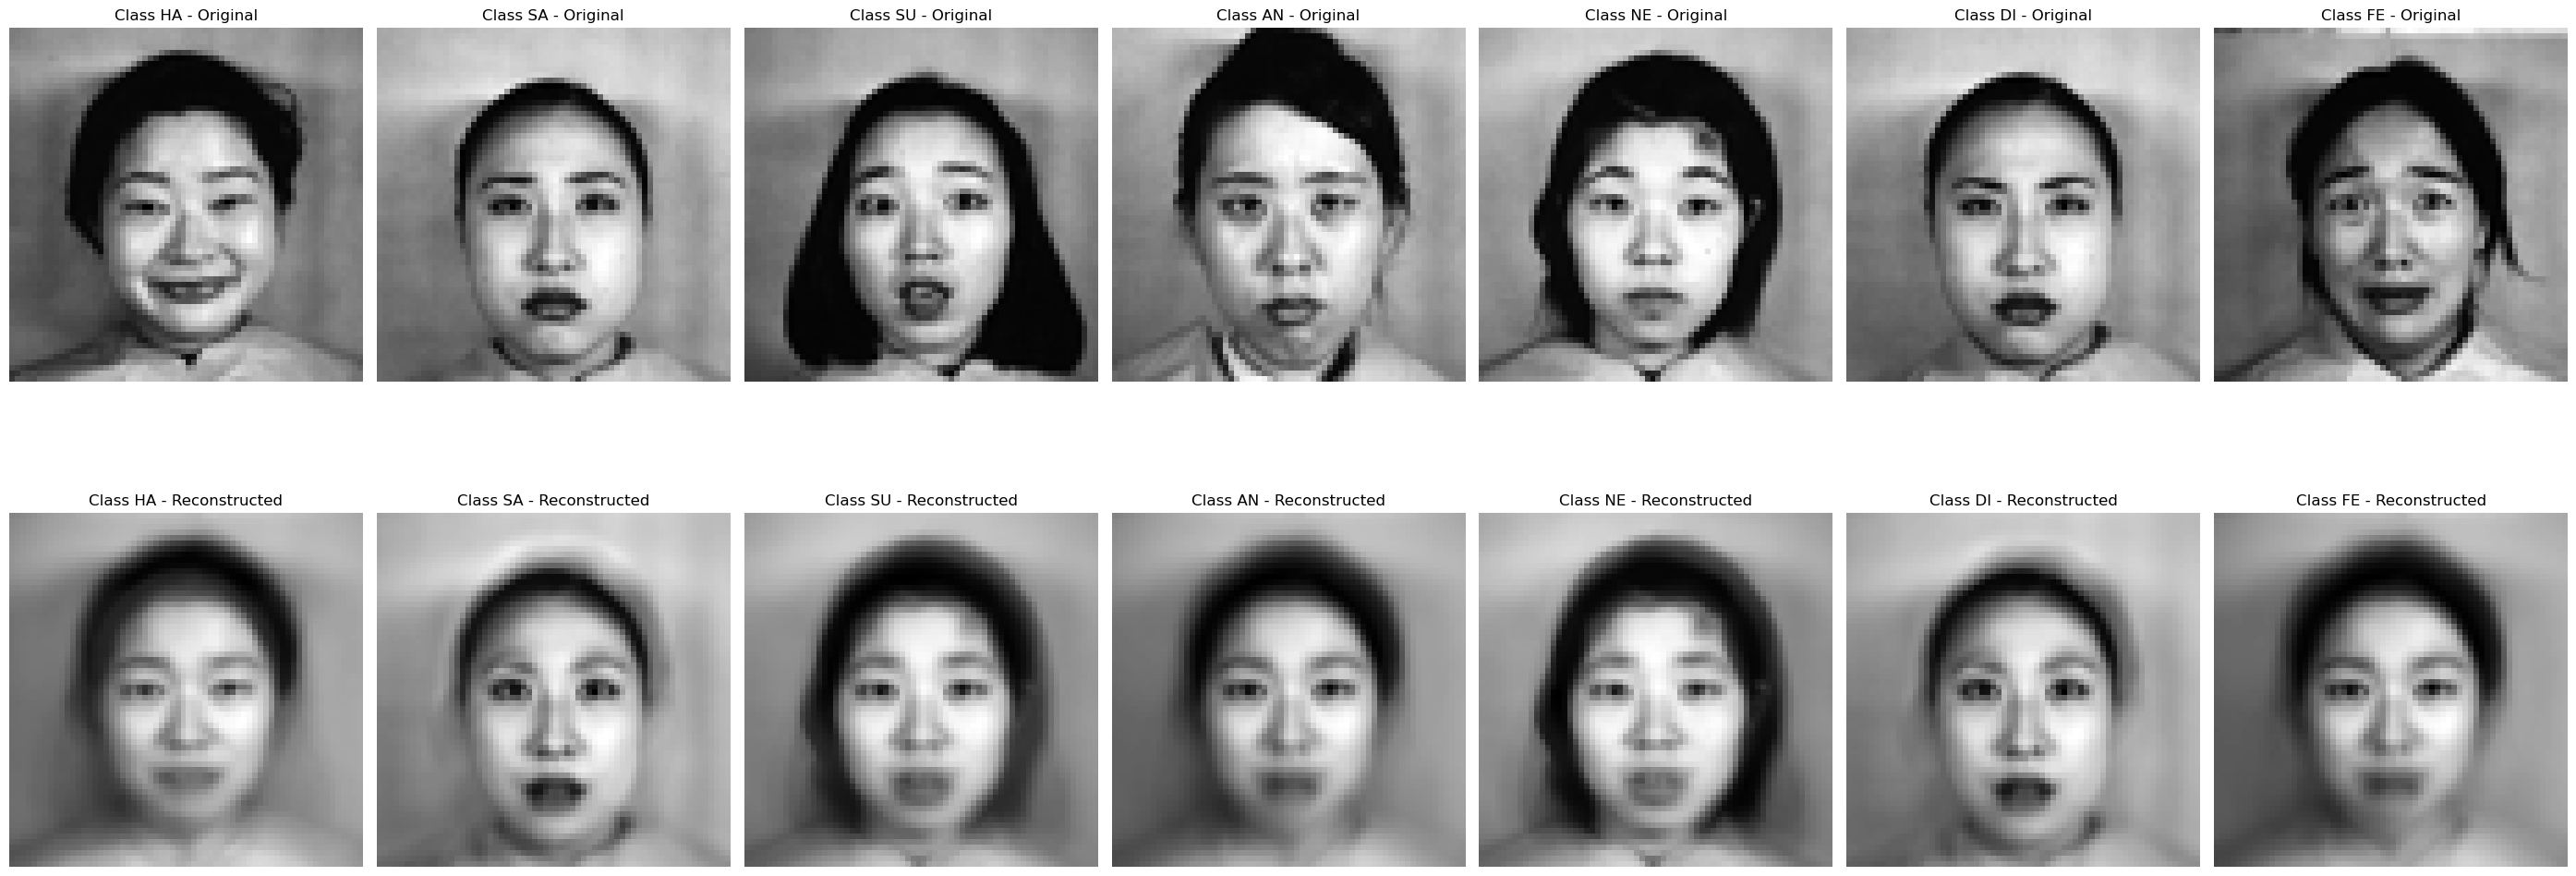

In [18]:
plot_inverse_transformation(reconstructed_images_2d, unique_classes, image_size)

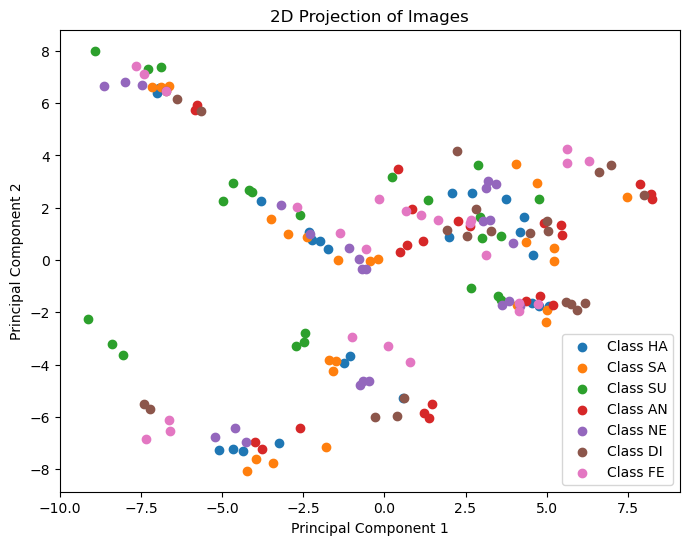

In [19]:
fig = plt.figure(figsize=(8, 6))
for class_label in unique_classes:
    class_indices = np.where(labels == class_label)[0]
    plt.scatter(transformed_images_2d[class_indices, 0], transformed_images_2d[class_indices, 1], label=f'Class {class_label}')

plt.title('2D Projection of Images')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.show()

In [20]:
n_components_3d = 3
image_size = (64,64)
pca_3d = PCA(n_components_3d)
pca_3d.fit(images)
transformed_images_3d = pca_3d.transform(images)
eigenfaces_3d = pca_3d.components.reshape((n_components_3d, *image_size))

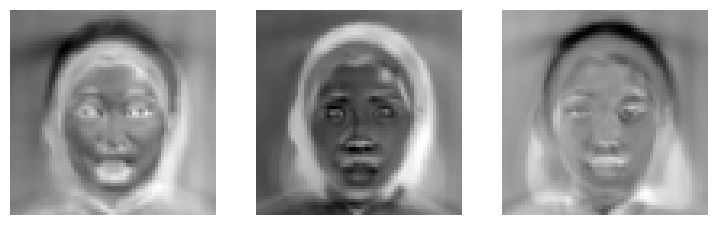

In [21]:
plot_eigenfaces(eigenfaces_3d)

In [22]:
labels = dataset['Expression']
unique_classes = list(set(labels))
reconstructed_images_3d = pca_3d.inverse_transform(transformed_images_3d)
reconstructed_images_3d = reconstructed_images_3d.reshape(-1, *image_size)

inverse transform images: 


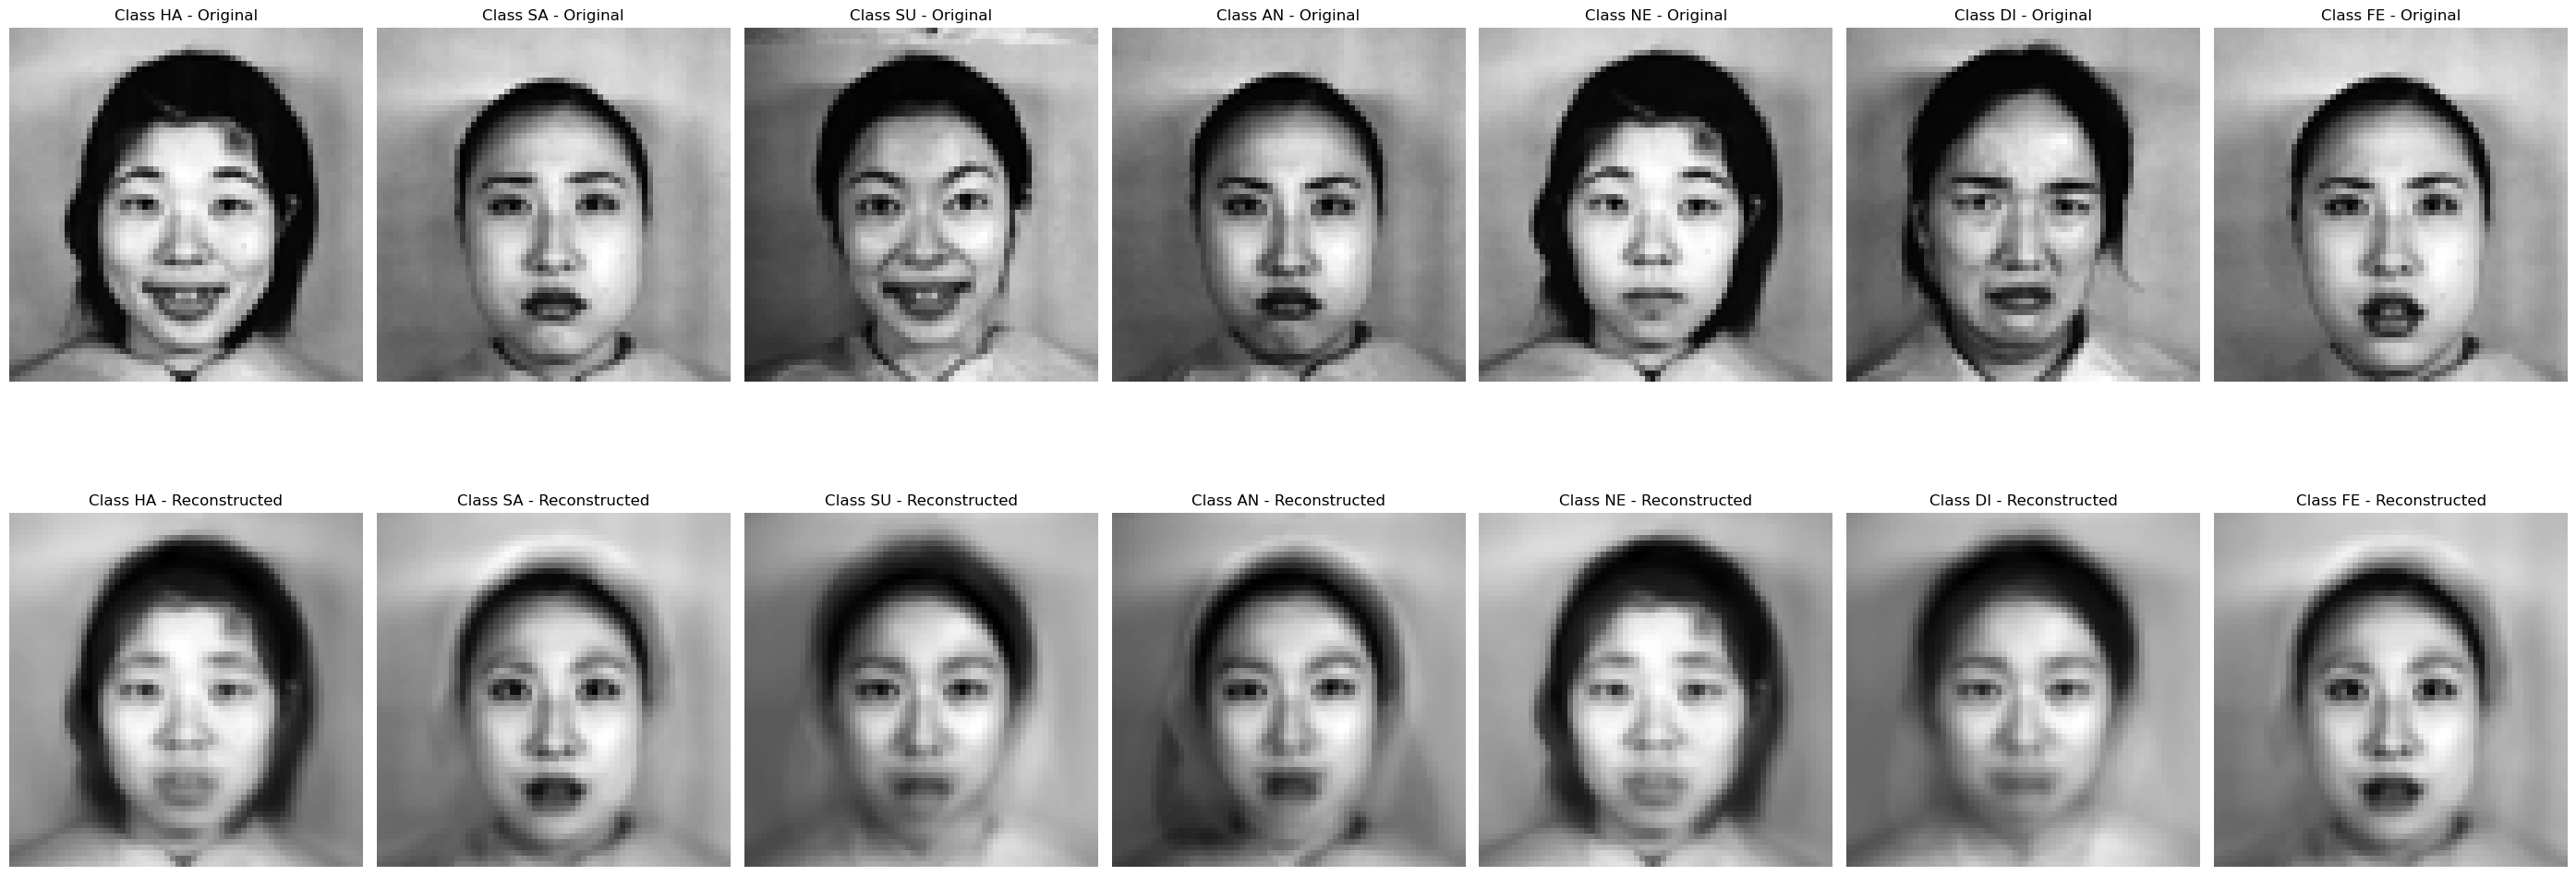

In [23]:
plot_inverse_transformation(reconstructed_images_3d, unique_classes, image_size)

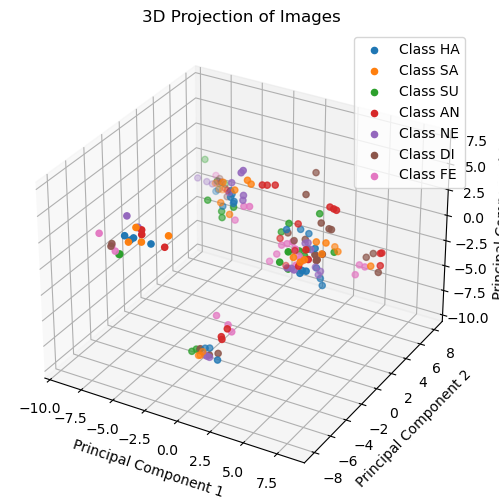

In [24]:
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

for class_label in unique_classes:
    class_indices = np.where(labels == class_label)[0]
    ax.scatter(transformed_images_3d[class_indices, 0], transformed_images_3d[class_indices, 1],
               transformed_images_3d[class_indices, 2], label=f'Class {class_label}')

ax.set_title('3D Projection of Images')
ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_zlabel('Principal Component 3')
ax.legend()
plt.show()

In [25]:
total_var = np.sum(pca.eigenvalues)
cumulative_variance = np.cumsum(pca.eigenvalues) / total_var
n_components_90_percent = np.argmax(cumulative_variance >= 0.9) + 1
print(f"Number of components needed for 90% cumulative variance: {n_components_90_percent}")

Number of components needed for 90% cumulative variance: 23


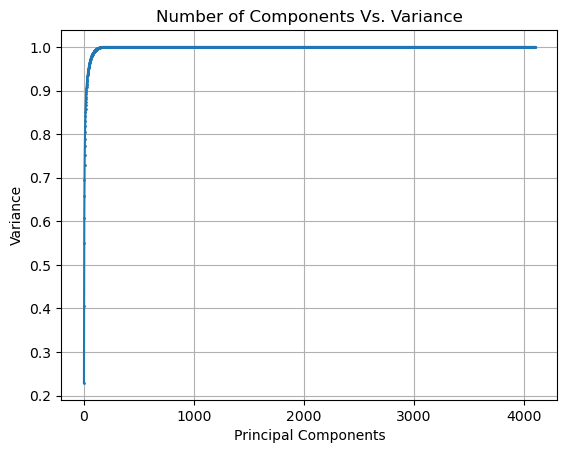

In [26]:
all_components = range(1,len(pca.eigenvalues)+1)
plt.title('Number of Components Vs. Variance')
plt.xlabel('Principal Components')
plt.ylabel('Variance')
plt.grid(True)
plt.plot(all_components, cumulative_variance ,'o-', markersize=1)
plt.show()

In [27]:
pca_90_percent = PCA(n_components_90_percent)
pca_90_percent.fit(images)
transformed_images_90_percent = pca_90_percent.transform(images)
eigenfaces_90_percent = pca_90_percent.components.reshape((n_components_90_percent, *image_size))

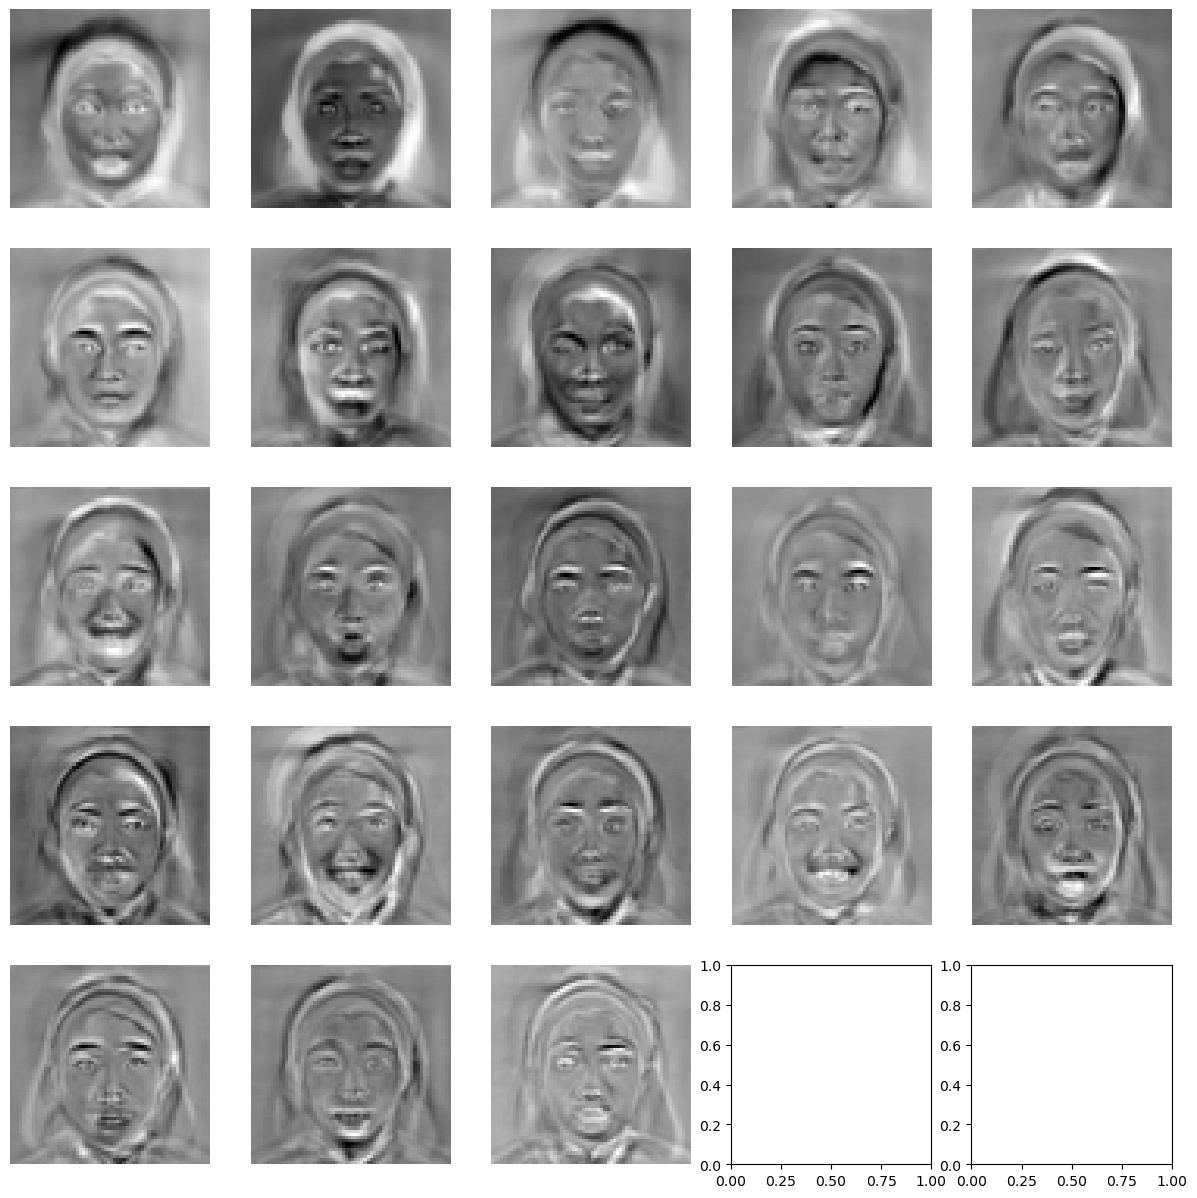

In [28]:
plot_eigenfaces(eigenfaces_90_percent)

In [29]:
labels = dataset['Expression']
unique_classes = list(set(labels))
reconstructed_images_90_percent = pca_90_percent.inverse_transform(transformed_images_90_percent)
reconstructed_images_90_percent = reconstructed_images_90_percent.reshape(-1, *image_size)

inverse transform images: 


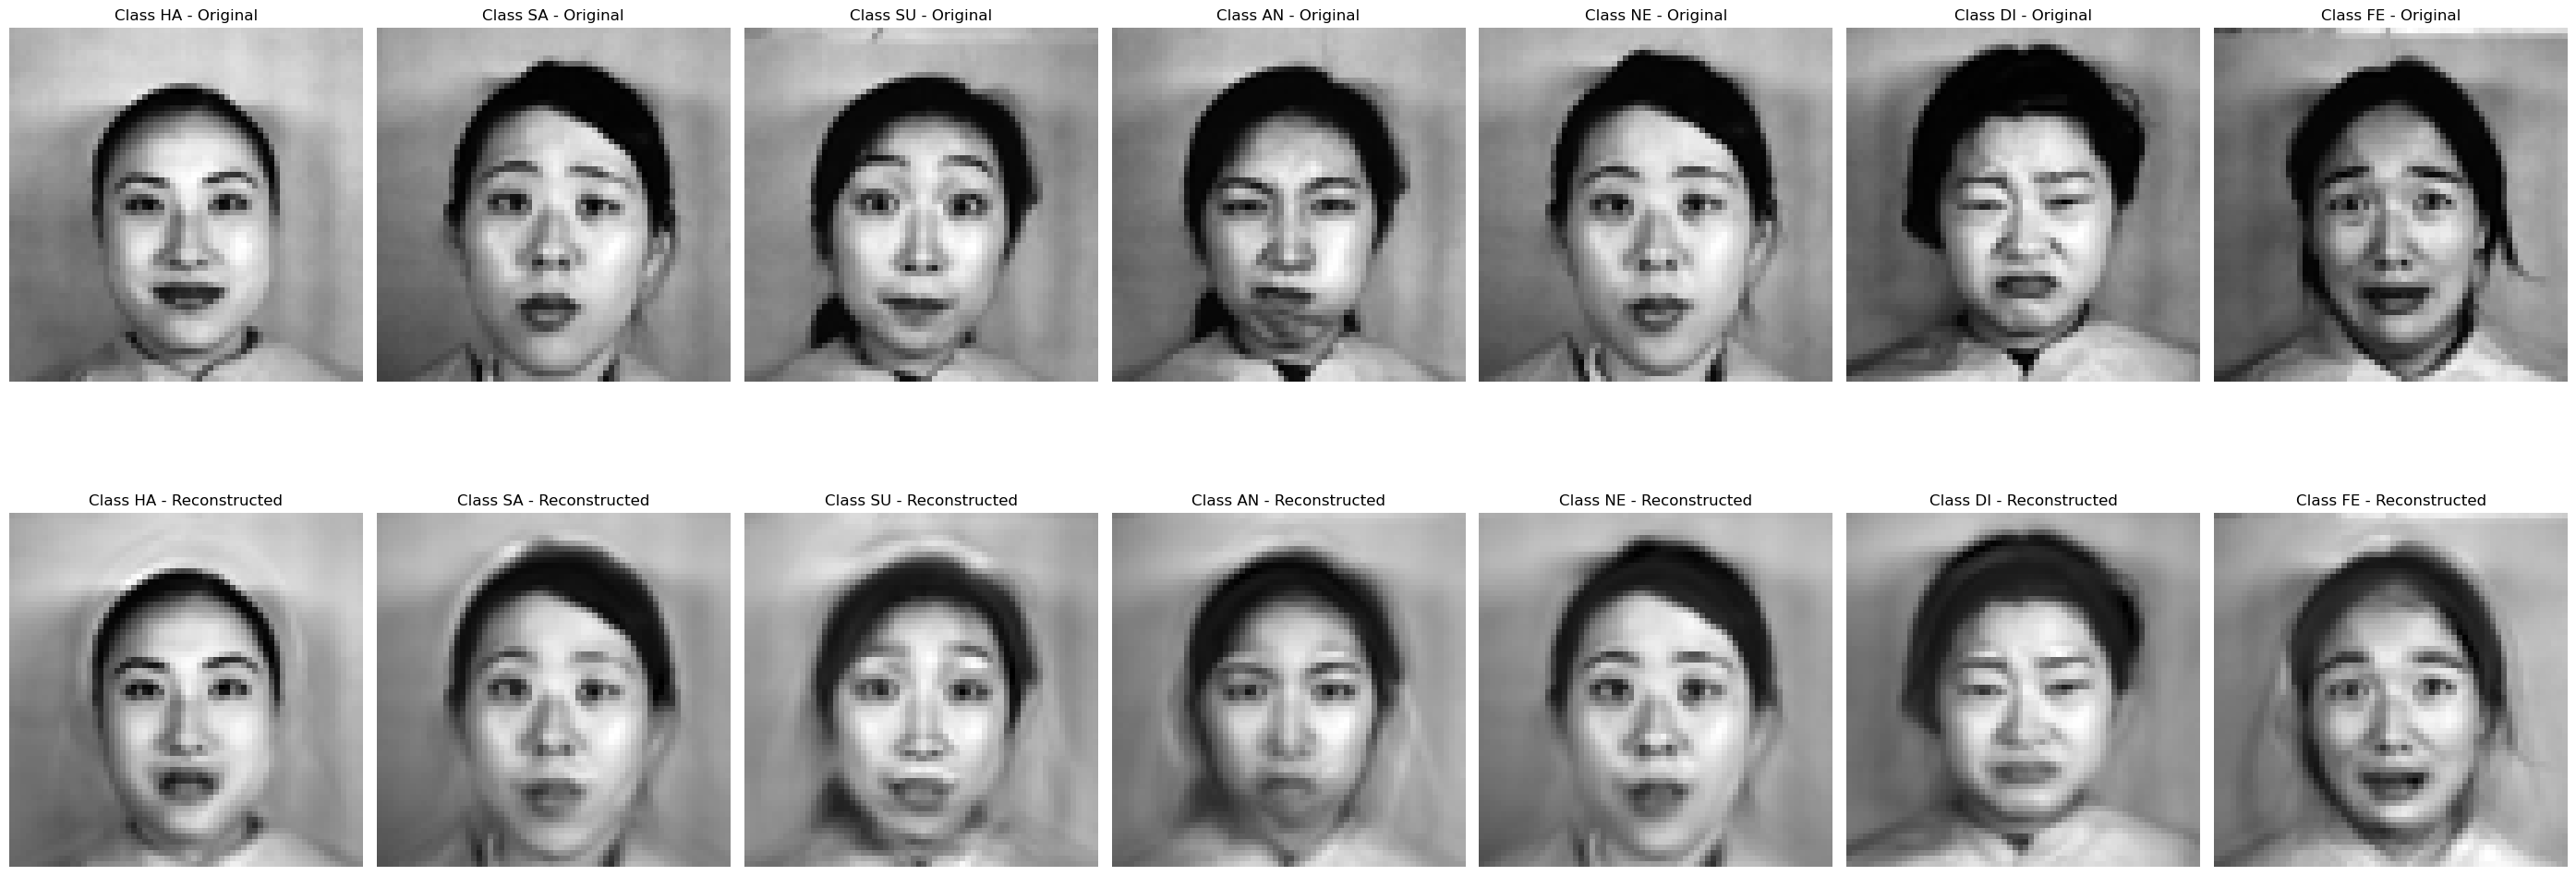

In [30]:
plot_inverse_transformation(reconstructed_images_90_percent, unique_classes, image_size)

In [31]:
transformed_images =  np.array([img.flatten() for img in transformed_images_90_percent])
label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(labels)
X_train, X_test, y_train, y_test = train_test_split(transformed_images, labels, test_size=0.3, random_state=42)

In [51]:
qda = QuadraticDiscriminantAnalysis(0.1)
qda.fit(X_train, y_train)

In [52]:
y_pred = qda.predict_likelihood(X_test)

In [53]:
accuracy_score(y_test, y_pred)

0.7450980392156863

It shows an increasing trend as the number of PCs increases. This is expected because more PCs mean that the classifier is provided with more information to distinguish between classes during training.


The optimal number of PCs is usually at the point where the test accuracy is highest. Beyond this point, adding more PCs does not improve and might even decrease the classifier's performance on the test set. 

as more PCs are added, they may start to capture more noise than signal. This noise does not generalize well, even to the training set, leading to a decline in training accuracy.

QDA works on the assumption that the data for each class can be modelled by a Gaussian distribution with a specific covariance matrix. As more dimensions are added, if these additional dimensions do not follow a Gaussian distribution or are not useful for class discrimination, the underlying assumptions of QDA may no longer hold, leading to a decrease in performance.

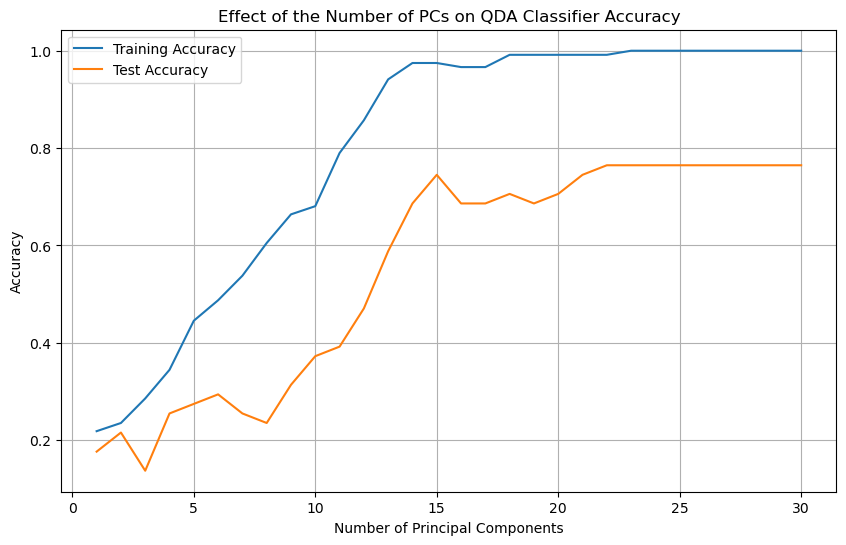

In [35]:
train_accuracies = []
test_accuracies = []
components_range = range(1, 31)

for n_components in components_range:
    pca = PCA(n_components=n_components)
    pca.fit(X_train)
    X_train_pca = pca.transform(X_train)
    X_test_pca = pca.transform(X_test)

    classifier = QuadraticDiscriminantAnalysis(0.1)
    classifier.fit(X_train_pca, y_train)

    # Training accuracy
    y_train_pred = classifier.predict_likelihood(X_train_pca)
    train_accuracy = accuracy_score(y_train, y_train_pred)
    train_accuracies.append(train_accuracy)

    # Test accuracy
    y_test_pred = classifier.predict_likelihood(X_test_pca)
    test_accuracy = accuracy_score(y_test, y_test_pred)
    test_accuracies.append(test_accuracy)

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(components_range, train_accuracies, label='Training Accuracy')
plt.plot(components_range, test_accuracies, label='Test Accuracy')
plt.xlabel('Number of Principal Components')
plt.ylabel('Accuracy')
plt.title('Effect of the Number of PCs on QDA Classifier Accuracy')
plt.legend()
plt.grid(True)
plt.show()
